# Classificação dos Dados

>

- Aplicação de qualquer algoritmo de classificação nos dados e realização das análises.

## Amostragem e treinamento dos dados

- É necessário ter o CSV dentro do Drive.
- Mudar o path do arquivo no `read_csv` para o caminho onde o CSV está no seu Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from collections import Counter
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/creditcard.csv')
data = data.drop_duplicates()
total = len(data.values)
normal = len(data[data['Class'] == 0])
fraud = len(data[data['Class'] == 1])
fraudpercentage = round((fraud/total)*100, 2)
normalpercentage = round((normal/total)*100, 2)

print('Total de transações:', total)
print('Total de transações legítimas:', normal)
print('Total de transações fraudulentas:', fraud)
print('Porcentagem de transações legítimas:', normalpercentage, '%')
print('Porcentagem de transações fraudulentas:', fraudpercentage, '%')

Total de transações: 283726
Total de transações legítimas: 283253
Total de transações fraudulentas: 473
Porcentagem de transações legítimas: 99.83 %
Porcentagem de transações fraudulentas: 0.17 %


**X e Y**  
Separar a lable 'Class' dos demais rótulos, pois é ela quem vai me dizer se a transação é ou não fraudulenta.

**Seleção de treinamento**  
Total  => 80% Treino | 20% Teste  
Treino => 20% Validação

Training set:
0    181275
1       309
Name: Class, dtype: int64


<Axes: ylabel='Class'>

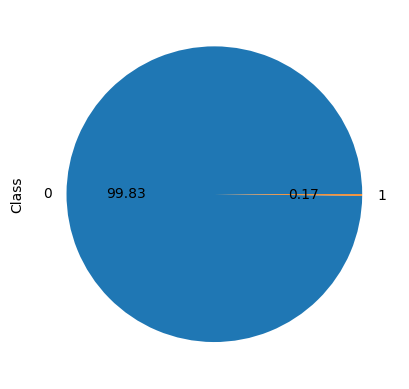

In [ ]:
from sklearn.model_selection import train_test_split

X = data.drop(['Class'], axis = 1)
y = data['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print('Training set:')
attributes = pd.DataFrame(X_train)
labels = pd.Series(y_train, name='Class')
df_train = pd.concat([attributes, labels], axis=1)


# Frequência de fraudes com gráfico de torta
class_counts = df_train["Class"].value_counts()
print(class_counts)
class_counts.plot.pie(autopct="%.2f")

## SMOTE
> Synthetic Minority Oversampling Technique é uma estratégia de oversampling baseada em vizinhos mais próximos para selecionar os objetos  a serem amostrados.

In [ ]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE

smote = BorderlineSMOTE(k_neighbors=3,m_neighbors=2,sampling_strategy='minority')
X_smote, y_smote = smote.fit_resample(X_train, y_train)

In [ ]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

df_balanceado = X_smote.copy()
df_balanceado['Class'] = y_smote.copy()
features = list(df_balanceado.columns)

print(df_balanceado.head())
print(features)

       Time        V1        V2        V3        V4        V5        V6  \
0  102291.0 -1.897072  2.248047  1.649964  2.710571  0.329392  0.890923   
1   41268.0 -2.823919  1.302152  0.890238  1.207886 -1.930150  0.308992   
2  151927.0 -1.248274  0.967119 -0.589003 -3.895591  0.032566 -1.463465   
3   32364.0 -0.819076  0.482289  2.750521  0.993578 -0.365897 -0.098022   
4  149792.0 -1.270305 -0.197522  1.946088 -0.668329  0.777826 -0.133728   

         V7        V8        V9  ...       V21       V22       V23       V24  \
0  0.334283  0.531197 -0.432901  ... -0.354512 -1.064076 -0.188763 -0.835751   
1 -1.240923  1.896302 -0.344546  ...  0.209775  0.239160  0.095515  0.068503   
2  0.529588  0.640274  1.071991  ... -0.083438 -0.588925 -0.083096  0.525241   
3  0.205540  0.021240  0.294658  ...  0.116182  0.628346 -0.274823  0.388308   
4 -0.179701  0.372234  0.120052  ...  0.388988  0.876318 -0.354844  0.777272   

        V25       V26       V27       V28  Amount  Class  
0  0.3081

#### Mapa de calor dos dados antes do balanceamento

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


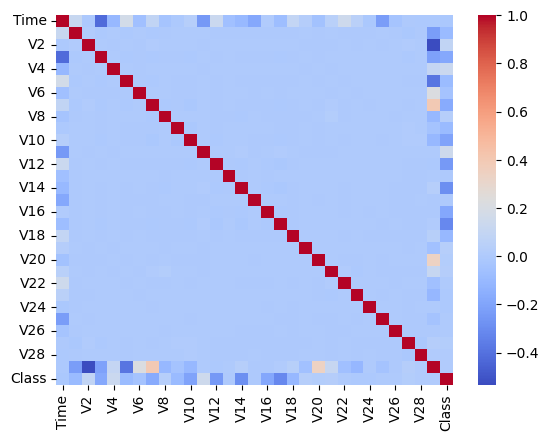

In [ ]:
corr_matrix = data.corr()
print(corr_matrix.columns)
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.savefig("heatmap-initial.png")

#### Mapa de calor após aplicar a técnica de SMOTE

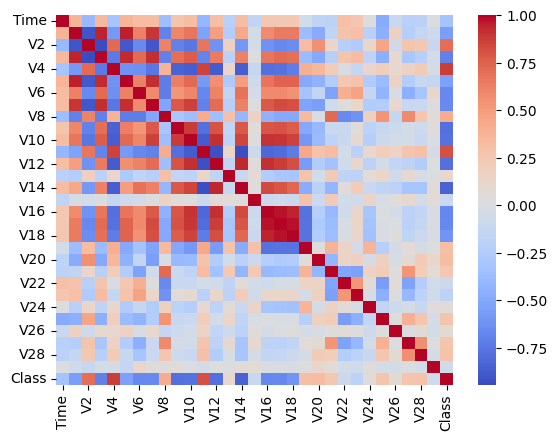

In [ ]:
corr_matrix = df_balanceado.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.savefig("heatmap-smote.png")

## Aplicação do algoritmo Decision Tree Classifier

Esse algoritmo serve para analisar as métricas de decisão através de árvores.

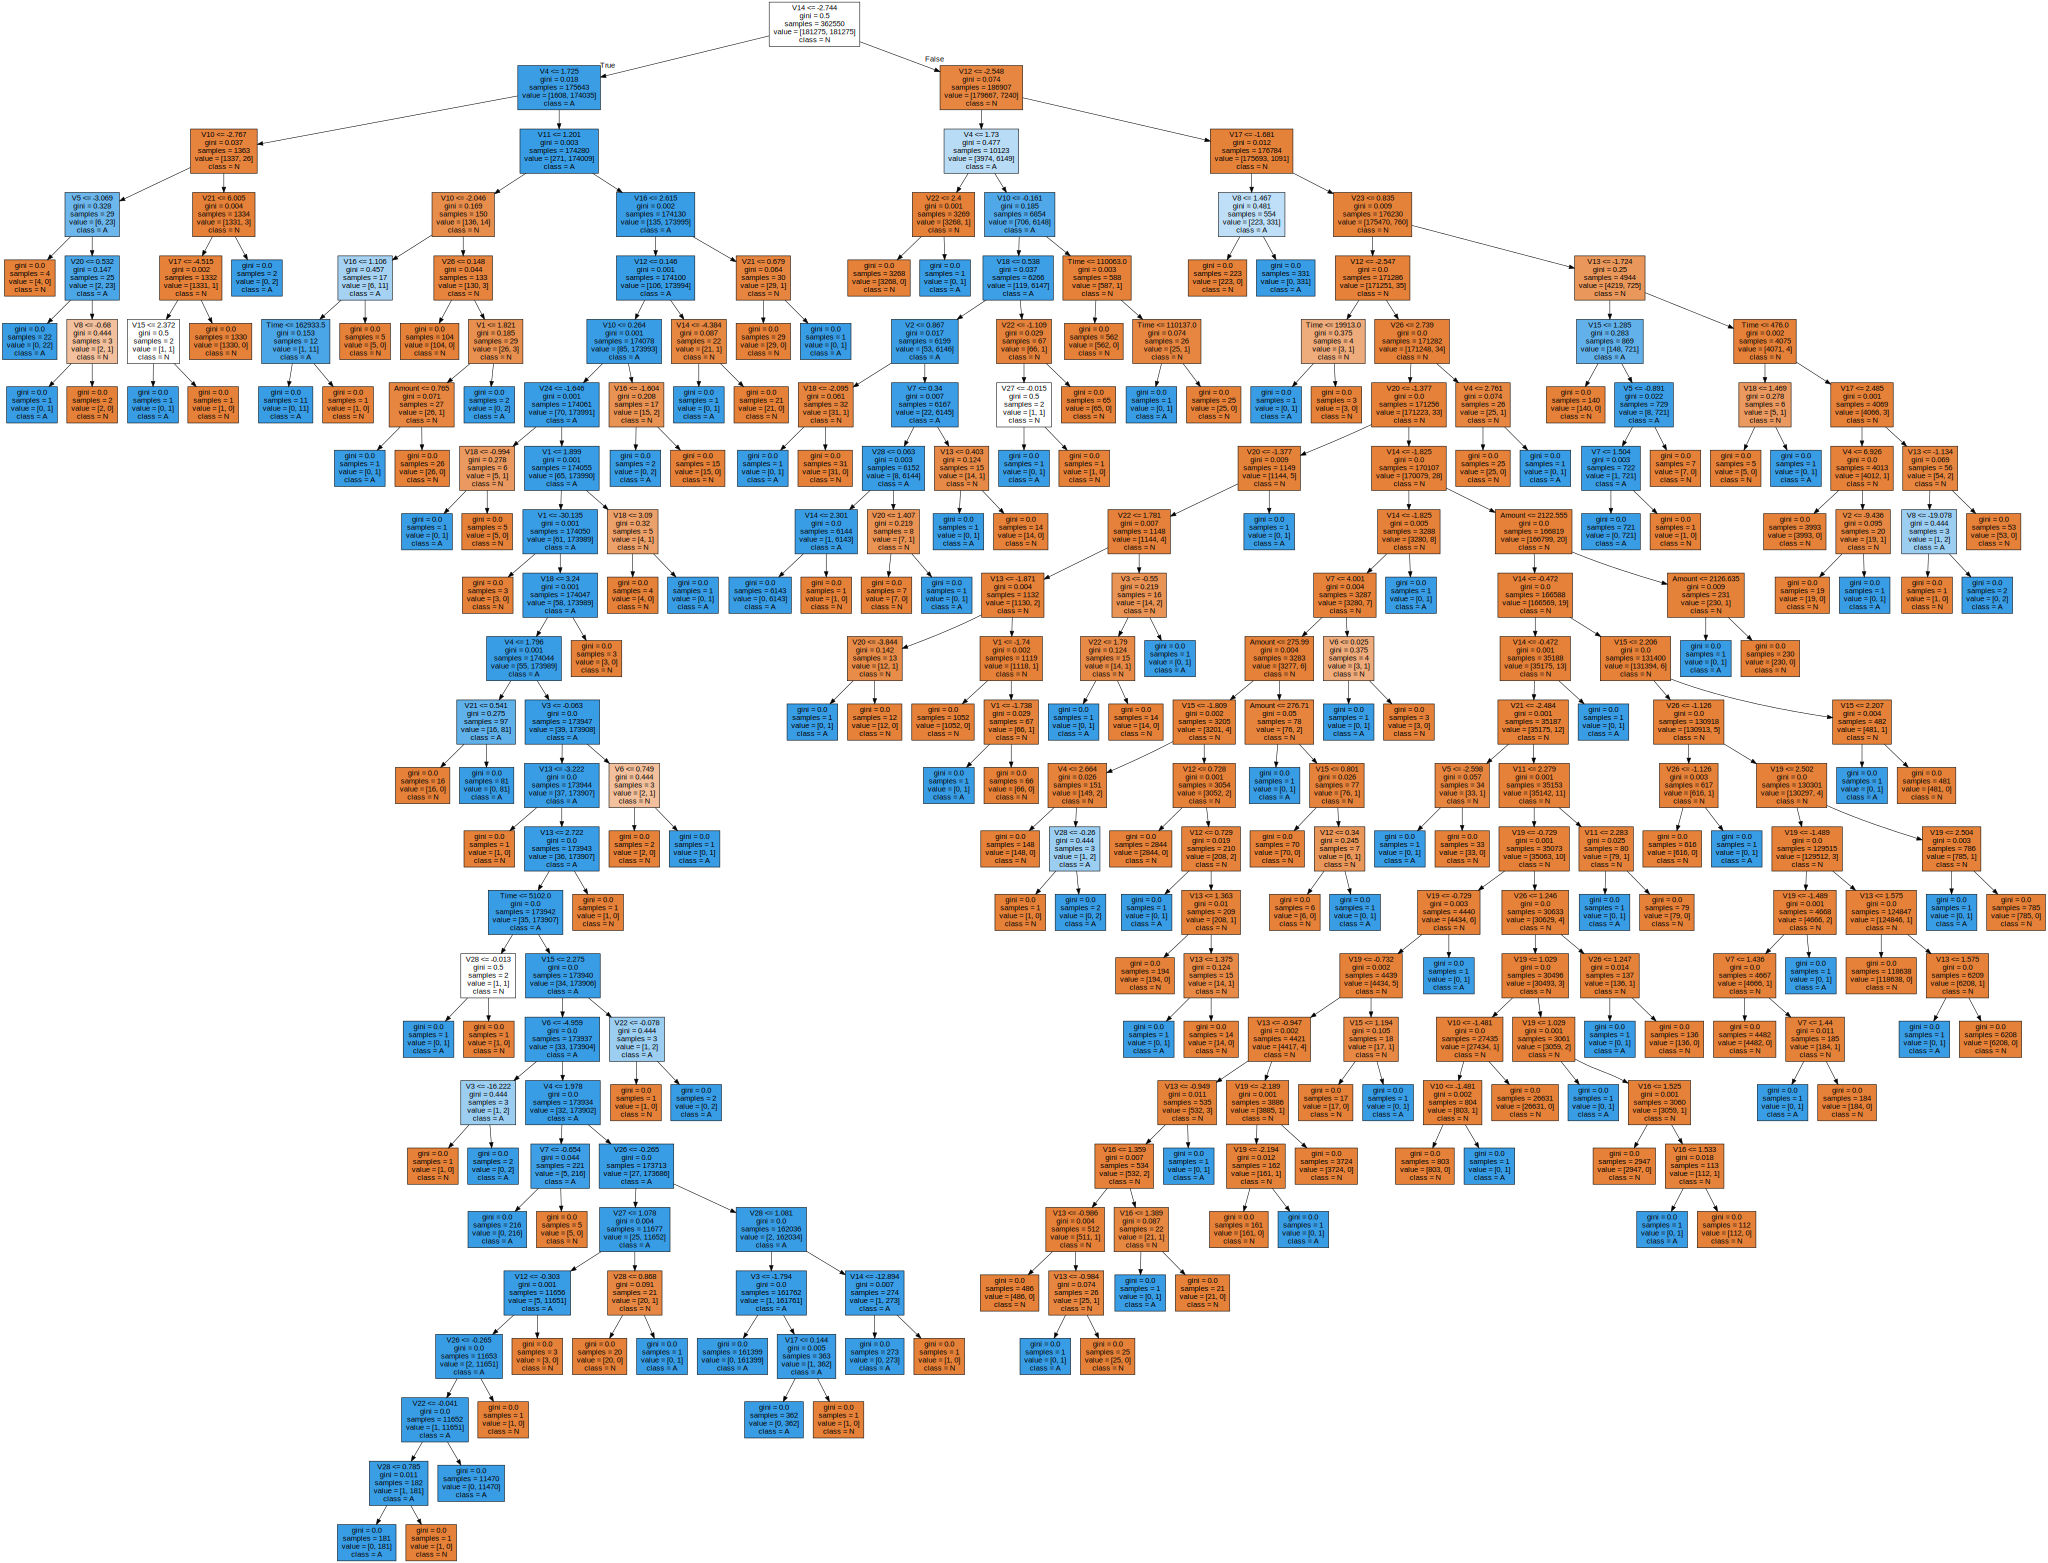

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
from sklearn.metrics import classification_report
from imblearn.metrics import classification_report_imbalanced

model = DecisionTreeClassifier()
model.fit(X_smote, y_smote)

dot_data = export_graphviz(model,
                           feature_names=df_balanceado.columns.drop('Class'),
                           class_names=['N', 'A'], filled=True)

graph = graphviz.Source(dot_data)
graph

#### Dados de treino vs Dados de validação

É possível notar que esse algoritmo acabou causando um overfitting, onde os dados de treino obtiveram resultados melhores em relação a base de dados de validação.

In [ ]:
y_pred = model.predict(X_train)
print('BL para dados treinados\n:',classification_report(y_train, y_pred))

print('IMBL para dados treinados\n:',classification_report_imbalanced(y_train, y_pred))

print('\n---\n')

y_pred = model.predict(X_val)
print('BL para dados de validação\n:',classification_report(y_val, y_pred))

print('IMBL para dados de validação\n:',classification_report_imbalanced(y_val, y_pred))

BL para dados treinados
:               precision    recall  f1-score   support

           0       1.00      1.00      1.00    181275
           1       1.00      1.00      1.00       309

    accuracy                           1.00    181584
   macro avg       1.00      1.00      1.00    181584
weighted avg       1.00      1.00      1.00    181584

IMBL para dados treinados
:                    pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      1.00      1.00      1.00      1.00    181275
          1       1.00      1.00      1.00      1.00      1.00      1.00       309

avg / total       1.00      1.00      1.00      1.00      1.00      1.00    181584


---

BL para dados de validação
:               precision    recall  f1-score   support

           0       1.00      1.00      1.00     45322
           1       0.78      0.78      0.78        74

    accuracy                           1.00     45396
   macro avg       0.89      0.

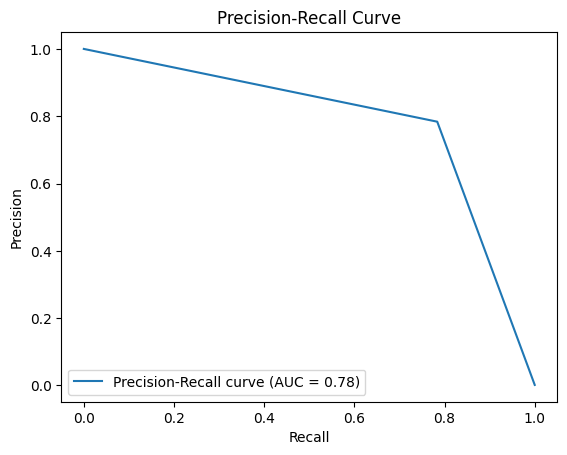

In [ ]:
from sklearn.metrics import precision_recall_curve, auc

#Calculando os valores de Precision e Recall
precision, recall, _ = precision_recall_curve(y_val, y_pred)
#Calculando area sobre a curva que plota Precision vs Recall
auc_pr = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve (AUC = %0.2f)' % auc_pr)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


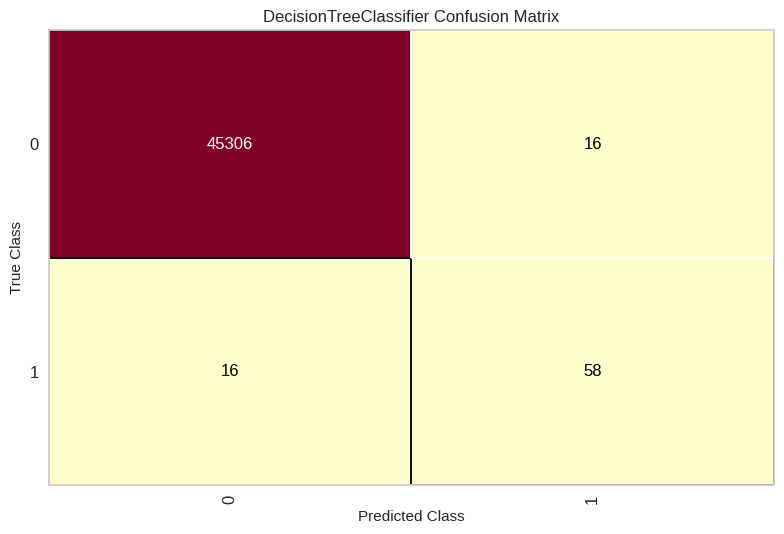

<Axes: title={'center': 'DecisionTreeClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [ ]:
from yellowbrick.classifier import ConfusionMatrix

cm_viz = ConfusionMatrix(model)
cm_viz.score(X_val, y_val)
cm_viz.show()

## Aplicação do algoritmo Random Forest


Em resumo, o Random Forest irá criar muitas árvores de decisão, de maneira aleatória, formando o que podemos enxergar como uma floresta, onde cada árvore será utilizada na escolha do resultado final, em uma espécie de votação.

Feita a aplicação desse algoritmo os resultados melhoraram muito, diminuindo o overfitting dos dados.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, mean_squared_error
from math import sqrt

rf = RandomForestClassifier(n_estimators=10, random_state=42)
rf.fit(X_smote, y_smote);

y_pred = rf.predict(X_train)
print('BL para dados treinados\n:',classification_report(y_train, y_pred))

print('IMBL para dados treinados\n:',classification_report_imbalanced(y_train, y_pred))

print('\n---\n')

y_pred = rf.predict(X_val)
print('BL para dados de validação\n:',classification_report(y_val, y_pred))

print('IMBL para dados de validação\n:',classification_report_imbalanced(y_val, y_pred))

BL para dados treinados
:               precision    recall  f1-score   support

           0       1.00      1.00      1.00    181275
           1       1.00      0.95      0.97       309

    accuracy                           1.00    181584
   macro avg       1.00      0.97      0.99    181584
weighted avg       1.00      1.00      1.00    181584

IMBL para dados treinados
:                    pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      0.95      1.00      0.97      0.95    181275
          1       1.00      0.95      1.00      0.97      0.97      0.94       309

avg / total       1.00      1.00      0.95      1.00      0.97      0.95    181584


---

BL para dados de validação
:               precision    recall  f1-score   support

           0       1.00      1.00      1.00     45322
           1       0.94      0.81      0.87        74

    accuracy                           1.00     45396
   macro avg       0.97      0.

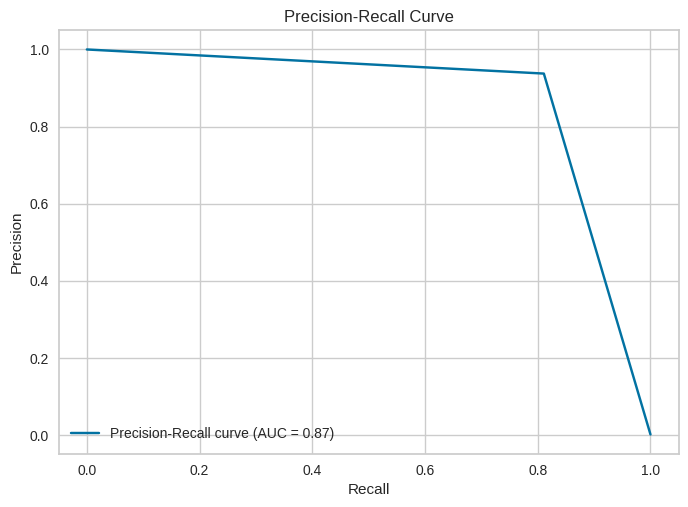

In [ ]:
#Calculando os valores de Precision e Recall
precision, recall, _ = precision_recall_curve(y_val, y_pred)
#Calculando area sobre a curva que plota Precision vs Recall
auc_pr = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve (AUC = %0.2f)' % auc_pr)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


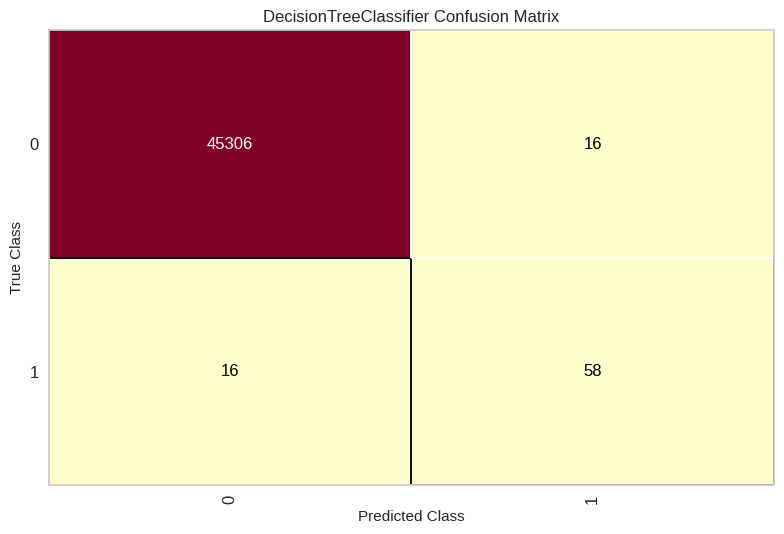

<Axes: title={'center': 'DecisionTreeClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [ ]:
from yellowbrick.classifier import ConfusionMatrix

cm_viz = ConfusionMatrix(model)
cm_viz.score(X_val, y_val)
cm_viz.show()